# Evaluate Various Models for CLA Data

## Import Statements

In [1]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from torch.autograd import Variable
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline
import errno
import os
import sys
import copy

## Define Helper Methods

In [2]:
def standardize(data):
    cont_features = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]    # features to be standardized (continuous)
    
    for feature in cont_features:
        data[:, feature] = preprocessing.scale(data[:, feature], axis=0, with_mean=True, with_std=True)
        
    return data

## Hyperparameters

In [3]:
sample_bias = 0     # adjust the difference in the number of the two types of samples (no algae vs algae)
test_size = 0.2
num_splits = 5
num_subsets = 5
batch_size = 96    # batch size for the DataLoaders

# NN model
num_features = 17
input_size = num_features     # size of input layer
multiplier = 100              # multiplied by num_features to determine the size of each hidden layer
hidden_size = multiplier * input_size
output_size = 1
learning_rate = 0.001         # learning rate of optimizer. previously was 0.01
num_epochs = 100              # number of epochs

## Read in Data

In [4]:
np.set_printoptions(threshold=np.inf)  # prints a full matrix rather than an abbreviated matrix
np.random.seed(0)

# define data and destination paths
dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"

X_2015 = np.load(data_path_hourly + 'hourly_X_2015.npy')
X_2016 = np.load(data_path_hourly + 'hourly_X_2016.npy')
X_2017 = np.load(data_path_hourly + 'hourly_X_2017.npy')
X_2018 = np.load(data_path_hourly + 'hourly_X_2018.npy')

y_2015 = np.load(data_path_hourly + 'hourly_y_2015.npy')
y_2016 = np.load(data_path_hourly + 'hourly_y_2016.npy')
y_2017 = np.load(data_path_hourly + 'hourly_y_2017.npy')
y_2018 = np.load(data_path_hourly + 'hourly_y_2018.npy')

lake_2014 = np.load(data_path_hourly + 'hourly_locations_2014.npy')
lake_2015 = np.load(data_path_hourly + 'hourly_locations_2015.npy')
lake_2016 = np.load(data_path_hourly + 'hourly_locations_2016.npy')
lake_2017 = np.load(data_path_hourly + 'hourly_locations_2017.npy')
lake_2018 = np.load(data_path_hourly + 'hourly_locations_2018.npy')

site_2014 = np.load(data_path_hourly + 'hourly_sites_2014.npy')
site_2015 = np.load(data_path_hourly + 'hourly_sites_2015.npy')
site_2016 = np.load(data_path_hourly + 'hourly_sites_2016.npy')
site_2017 = np.load(data_path_hourly + 'hourly_sites_2017.npy')
site_2018 = np.load(data_path_hourly + 'hourly_sites_2018.npy')

# X = X_2017.astype(float)
# y = y_2017
# lakes = lake_2017
# sites = site_2017
X = np.vstack((X_2015, X_2016, X_2017, X_2018)).astype(float)
y = np.hstack((y_2015, y_2016, y_2017, y_2018))
lakes = np.hstack((lake_2015, lake_2016, lake_2017, lake_2018))
sites = np.hstack((site_2015, site_2016, site_2017, site_2018))

num_features = X.shape[1]

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: 0 for no algae and 1 for algae
for i in range(0, len(y)):
    if y[i] == 0:
        num_no_alg += 1
    if y[i] >= 1:
        y[i] = 1
        num_alg += 1

# # split dataset by lake locations
# lake_dict = {
#     'Mendota': 0,
#     'Monona': 1,
#     'Kegonsa': 2,
#     'Wingra': 3,
#     'Waubesa': 4
# }

# # split data set by location
# lake = [lake_dict[lakes[i]] for i in range(len(lakes))]

# # define indices that mark the end of each lake location in the data set. Waubesa doesnt need one since it is
# # the last location
# mendota_idx = lake.count(0)
# monona_idx = mendota_idx + lake.count(1)
# kegonsa_idx = monona_idx + lake.count(2)
# wingra_idx = kegonsa_idx + lake.count(3)

# lake = np.asarray(lake)
# lake_sort_idx = np.argsort(lake, kind='mergesort')
# lake = lake[lake_sort_idx]
# X = X[lake_sort_idx, :]
# y = y[lake_sort_idx]

# # split data
# mendota_X = X[:mendota_idx, :]
# mendota_y = y[:mendota_idx]

# monona_X = X[mendota_idx:monona_idx, :]
# monona_y = y[mendota_idx:monona_idx]

# kegonsa_X = X[monona_idx:kegonsa_idx, :]
# kegonsa_y = y[monona_idx:kegonsa_idx]

# wingra_X = X[kegonsa_idx:wingra_idx, :]
# wingra_y = y[kegonsa_idx:wingra_idx]

# waubesa_X = X[wingra_idx:, :]
# waubesa_y = y[wingra_idx:]

# X = mendota_X
# y = mendota_y

# split data set by site
site_dict = {}
count = 0
for i in range(len(sites)):
    if sites[i] not in site_dict:
        site_dict[sites[i]] = count
        count += 1

site = [site_dict[sites[i]] for i in range(len(sites))]

site_idx = []
for i in range(len(site_dict)):
    if i == 0:
        site_idx.append(site.count(i))
    else:
        site_idx.append(site_idx[i-1] + site.count(i))
#     print(site.count(i), i)

site = np.asarray(site)
site_sort_idx = np.argsort(site, kind='mergesort')
site = site[site_sort_idx]
X = X[site_sort_idx, :]
y = y[site_sort_idx]

X = X[site_idx[37]:site_idx[38], :]
y = y[site_idx[37]:site_idx[38]]
site = site[site_idx[37]:site_idx[38]]

In [5]:
# Shuffle the data
shuff_idx = np.arange(X.shape[0])
np.random.shuffle(shuff_idx)

X = X[shuff_idx, :]
y = y[shuff_idx]

In [6]:
# Read in data for plotting ROC and PR Curves

# k-NN and Logistic Regression
# X_train_curve = np.load(dest_path + "X_train_curve.npy")
# X_test_curve = np.load(dest_path + "X_test_curve.npy")
# y_train_curve = np.load(dest_path + "y_train_curve.npy")
# y_test_curve = np.load(dest_path + "y_test_curve.npy")

# Neural Network
# train_loader_curve = torch.load(dest_path + "train_loader_curve.pt")
# test_loader_curve = torch.load(dest_path + "test_loader_curve.pt")

In [7]:
# determine weight vector for the each class; used in defining some of the models
num_neg = y.tolist().count(0)
weight_neg = 1 / num_neg
num_pos = y.tolist().count(1)
weight_pos = 1 / num_pos
weight = {
    0 : weight_neg,
    1 : weight_pos
}

print(num_neg, num_pos)

271 42


## Define Models

### SVMs

In [8]:
linear_svc = svm.LinearSVC(
    penalty="l2",
    # loss="hinge",
    dual=False,
    tol=0.0001,
    C=10,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight='balanced',
    verbose=False,
    max_iter=1000
)

In [9]:
rbf_svc = svm.SVC(
    C=100,
    kernel="rbf",
    gamma="auto",
    probability=False,
    shrinking=True,
    class_weight='balanced',
    tol=0.0001,
    verbose=False,
    max_iter=-1,
)

In [10]:
poly_svc = svm.SVC(
    C=100,
    kernel="poly",
    degree=4,
    gamma="auto",
    coef0=1,
    probability=False,
    shrinking=True,
    class_weight='balanced',
    tol=0.0001,
    verbose=False,
    max_iter=-1,
)

### Logistic Regression

In [11]:
logistic = LogisticRegression(
#    penalty='l1',
    dual=False,
    tol=0.0001,
    C=100,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight='balanced',
    random_state=None,
    solver='liblinear',
    max_iter=1000,
    verbose=False,
    warm_start=False
)

### Random Forest

In [12]:
rand = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',   # also try 'entropy'
    max_depth=100,
    max_features='sqrt',
    bootstrap=True,
    oob_score=False,
    class_weight='balanced'
)

### K-Nearest Neighbors

In [13]:
k = 2
knn = KNeighborsClassifier(
    n_neighbors=k,
    weights="uniform",
    algorithm="brute",
    p=2,
    metric="minkowski",
    n_jobs=None
)

### Neural Network

In [14]:
class CLANet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size, output_size)
        self.sig1 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.tanh2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.tanh4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        out = self.sig1(out)
        return out

In [15]:
model = CLANet(input_size, hidden_size, output_size)
model.load_state_dict(torch.load(dest_path + "torch_model_4_6_19_lr=0.001_dict.pt"))
model.double()     # cast model parameters to double
model.eval();

## Run Models

In [16]:
# Perform CV on all models
skf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=False)

linear_svc_acc = [0] * num_subsets
rbf_svc_acc = [0] * num_subsets
poly_svc_acc = [0] * num_subsets
logistic_acc = [0] * num_subsets
knn_acc = [0] * num_subsets

fold = 1
print("Fold #: ", end=" ")

for train_idx, test_idx in skf.split(X, y):
    print(str(fold), end=" ")
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    
    #X_train = standardize(X_train)
    #X_test = standardize(X_test)
    
    X_train = preprocessing.scale(X_train, axis=1, with_mean=True, with_std=True)
    X_test = preprocessing.scale(X_test, axis=1, with_mean=True, with_std=True)
    
    #X_train = preprocessing.normalize(X_train, axis=1)
    #X_test = preprocessing.normalize(X_test, axis=1)
    
    for i in range(num_subsets):
        sub_idx = int(np.floor(((i+1) * X_train.shape[0])) / float(num_subsets))
        X_train_sub = X_train[:sub_idx, :]
        
        y_train_sub = y_train[:sub_idx]
        
        # SVMs
        #linear_svc.fit(X_train_sub, y_train_sub)
        #linear_svc_pred = linear_svc.predict(X_test)

        rbf_svc.fit(X_train_sub, y_train_sub)
        rbf_svc_pred = rbf_svc.predict(X_test)

        poly_svc.fit(X_train_sub, y_train_sub)
        poly_svc_pred = poly_svc.predict(X_test)

        # logistic
        logistic.fit(X_train_sub, y_train_sub)
        logistic_pred = logistic.predict(X_test)
        logistic_prob = logistic.predict_proba(X_test)[:, 1]

        # knn
        knn.fit(X_train_sub, y_train_sub)
        knn_pred = knn.predict(X_test)
        knn_prob = knn.predict_proba(X_test)[:, 1]

        # accuracy calculation
        #linear_svc_acc[i] += (np.sum(linear_svc_pred == y_test) / len(y_test))
        rbf_svc_acc[i] += (np.sum(rbf_svc_pred == y_test) / len(y_test))
        poly_svc_acc[i] += (np.sum(poly_svc_pred == y_test) / len(y_test))
        logistic_acc[i] += (np.sum(logistic_pred == y_test) / len(y_test))
        knn_acc[i] += (np.sum(knn_pred == y_test) / len(y_test))
    
    fold += 1
        
linear_svc_acc[:] = [float(i) / float(num_splits) for i in linear_svc_acc]
rbf_svc_acc[:] = [float(i) / float(num_splits) for i in rbf_svc_acc]
poly_svc_acc[:] = [float(i) / float(num_splits) for i in poly_svc_acc]
logistic_acc[:] = [float(i) / float(num_splits) for i in logistic_acc]
knn_acc[:] = [float(i) / float(num_splits) for i in knn_acc]

Fold #:  1 2 3 4 5 

## Plot Results

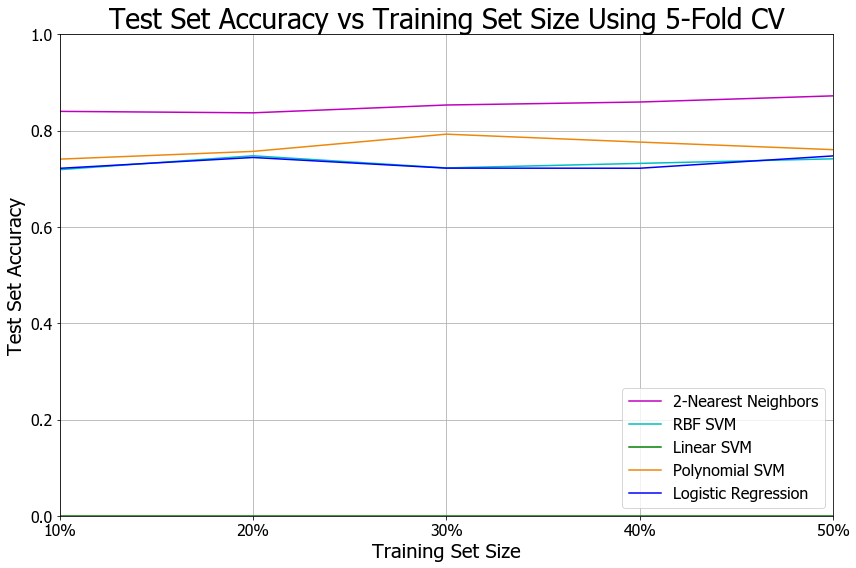

In [17]:
folds = [i+1 for i in range(num_splits)]

plt.figure(figsize=(12, 8))
plt.plot(folds, knn_acc, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(folds, rbf_svc_acc, color="c", label="RBF SVM")
plt.plot(folds, linear_svc_acc, color="g", label="Linear SVM")
plt.plot(folds, poly_svc_acc, color="#ed870b", label="Polynomial SVM")
plt.plot(folds, logistic_acc, color="b", label="Logistic Regression")
# plt.plot(folds, LS_acc, color="r", label="Least Squares")
plt.xlabel("Training Set Size", fontsize=20)
plt.xticks(np.arange(num_subsets)+1, ("10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"), fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Test Set Accuracy", fontsize=20)
plt.title("Test Set Accuracy vs Training Set Size Using " + str(num_splits) + "-Fold CV", fontsize=28)
plt.axis([1, num_splits, 0, 1])
plt.legend(loc="lower right", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
#plt.savefig("learning-curve.png", dpi=300)

## ROC and PR Curves

In [18]:
# Make predictions on allocated data sets
#knn.fit(X_train_curve, y_train_curve)
#knn_prob = knn.predict_proba(X_test_curve)[:, 1]

#logistic.fit(X_train_curve, y_train_curve)
#logistic_prob = logistic.predict_proba(X_test_curve)[:, 1]

#for i, (samples, labels) in enumerate(test_loader_curve):
#    samples = Variable(samples)
#    labels = Variable(labels)
#    conf = model(samples)    # confidence that a certain instance is predicted correctly
#    conf = torch.flatten(conf)
#    labels = labels.type(torch.DoubleTensor)
    
# convert to numpy arrays
#conf = conf.detach().numpy()
#labels = labels.numpy()

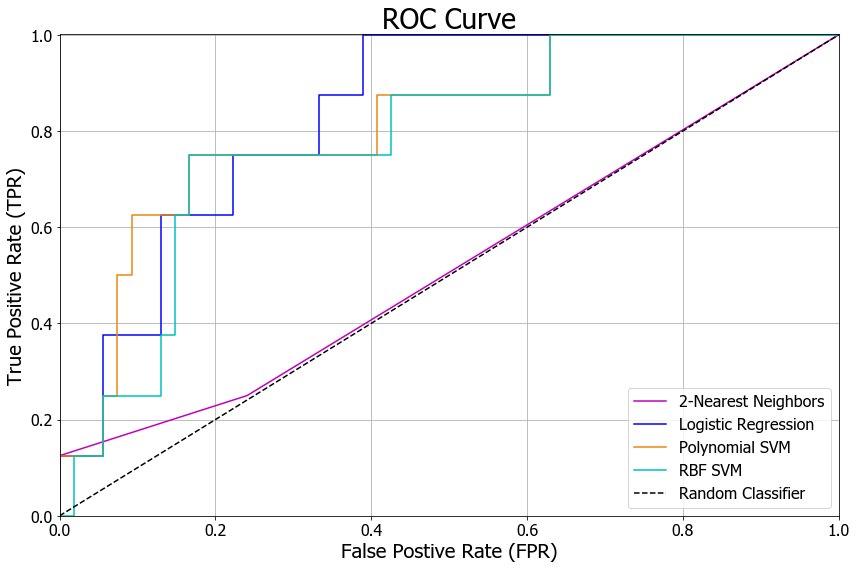

In [19]:
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob, pos_label=1)
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_prob, pos_label=1)
poly_fpr, poly_tpr, _ = roc_curve(y_test, poly_svc.decision_function(X_test), pos_label=1)
rbf_fpr, rbf_tpr, _ = roc_curve(y_test, rbf_svc.decision_function(X_test), pos_label=1)

plt.figure(figsize=(12, 8))
plt.plot(knn_fpr, knn_tpr, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(logistic_fpr, logistic_tpr, "b", label="Logistic Regression")
plt.plot(poly_fpr, poly_tpr, "#ed870b", label="Polynomial SVM")
plt.plot(rbf_fpr, rbf_tpr, "c", label="RBF SVM")
plt.plot(0.1*np.arange(12), 0.1*np.arange(12), color="k", linestyle="dashed", label="Random Classifier")
plt.xlabel("False Postive Rate (FPR)", fontsize=20)
plt.ylabel("True Positive Rate (TPR)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title("ROC Curve", fontsize=28)
plt.legend(loc="lower right", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
#savefig("roc-curve.png", dpi=300)

In [20]:
print("AUC Scores:")
print("\tk-NN:", roc_auc_score(y_test, knn_prob))
print("\tLogistic Regression:", roc_auc_score(y_test, logistic_prob))
print("\tPolynomial SVM:", roc_auc_score(y_test, poly_svc.decision_function(X_test)))
print("\tRBF SVM:", roc_auc_score(y_test, rbf_svc.decision_function(X_test)))

AUC Scores:
	k-NN: 0.5196759259259259
	Logistic Regression: 0.8356481481481483
	Polynomial SVM: 0.8125
	RBF SVM: 0.7847222222222222


In [24]:
confusion_matrix(y_true=y_test, y_pred=rbf_svc_pred)

array([[43, 11],
       [ 2,  6]])

## PR Curve

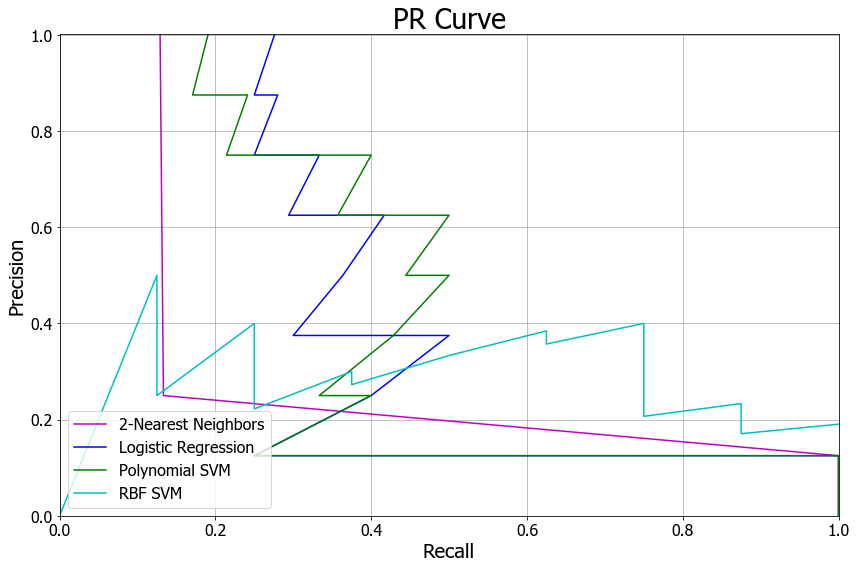

In [37]:
knn_prec, knn_recall, _ = precision_recall_curve(y_test, knn_prob, pos_label=1)
logistic_prec, logistic_recall, _ = precision_recall_curve(y_test, logistic_prob, pos_label=1)
poly_prec, poly_recall, _ = precision_recall_curve(y_test, poly_svc.decision_function(X_test), pos_label=1)
rbf_prec, rbf_recall, _ = precision_recall_curve(y_test, rbf_svc.decision_function(X_test), pos_label=1)

plt.figure(figsize=(12, 8))
plt.plot(knn_prec, knn_recall, color="m", label=str(k) + "-Nearest Neighbors")
plt.plot(logistic_prec, logistic_recall, "b", label="Logistic Regression")
plt.plot(poly_prec, poly_recall, "g", label="Polynomial SVM")
plt.plot(rbf_recall, rbf_prec, "c", label="RBF SVM")
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, 1, 0, 1.001])
plt.title("PR Curve", fontsize=28)
plt.legend(loc="lower left", prop={"size": 16})
plt.tight_layout()
plt.grid(True)
#plt.savefig("pr-curve.png", dpi=300)

## Make Predictions on Past Years

### Read in Data

In [ ]:
# define data and destination paths
# dest_path = "/Users/Alliot/Documents/CLA-Project/Data/all-data-no-na/neural-network/"
# data_path_hourly = "/Users/Alliot/Documents/CLA-Project/Data/hourly-data-sets/"
# data_path = "/Users/Alliot/Documents/CLA-Project/Data/data-sets/"
# year = 2016

# load data sets
# past_X = np.load(data_path_hourly + "hourly_X_" + str(year) + ".npy")
# past_y = np.load(data_path_hourly + "hourly_y_" + str(year) + ".npy")
# past_loc = np.load(data_path_hourly + "hourly_locations_" + str(year) + ".npy")
# past_X = past_X.astype(float)
# past_y = past_y.astype(int)

past_X = X_2016
past_y = y_2016
past_lake = lake_2016
past_site = site_2016

num_features = past_X.shape[1]

# manipulate data set. labels are converted to 0, +1 for binary classification; samples are removed uniformly 
# from the data set so that the disproportionately large number of negative samples (no algae) does 
# not bias the model.

num_alg = 0  # count the number of algae instances
num_no_alg = 0  # count the number of no algae instances

# Convert labels to binary: 0 for no algae and 1 for algae
for i in range(0, len(past_y)):
    if past_y[i] == 0:
        num_no_alg += 1
    if past_y[i] == 1 or past_y[i] == 2:
        past_y[i] = 1
        num_alg += 1

# split data set by location
# past_loc = [loc_dict[past_loc[i]] for i in range(len(past_loc))]

# # define indices that mark the end of each lake location in the data set. Waubesa doesnt need one since it is
# # the last location
# past_mendota_idx = past_loc.count(0)
# past_monona_idx = past_mendota_idx + past_loc.count(1)
# past_kegonsa_idx = past_monona_idx + past_loc.count(2)
# past_wingra_idx = past_kegonsa_idx + past_loc.count(3)

# past_loc = np.asarray(past_loc)
# past_sort_idx = np.argsort(past_loc, kind='mergesort')
# past_loc = past_loc[past_sort_idx]
# past_X = past_X[past_sort_idx, :]
# past_y = past_y[past_sort_idx]

# # split data
# past_mendota_X = past_X[:past_mendota_idx, :]
# past_mendota_y = past_y[:past_mendota_idx]

# past_monona_X = past_X[past_mendota_idx:past_monona_idx, :]
# past_monona_y = past_y[past_mendota_idx:past_monona_idx]

# past_kegonsa_X = past_X[past_monona_idx:past_kegonsa_idx, :]
# past_kegonsa_y = past_y[past_monona_idx:past_kegonsa_idx]

# past_wingra_X = past_X[past_kegonsa_idx:past_wingra_idx, :]
# past_wingra_y = past_y[past_kegonsa_idx:past_wingra_idx]

# past_waubesa_X = past_X[past_wingra_idx:, :]
# past_waubesa_y = past_y[past_wingra_idx:]

# past_X = past_mendota_X
# past_y = past_mendota_y
        
# # Shuffle the data
# shuff_idx = np.arange(past_X.shape[0])
# np.random.shuffle(shuff_idx)

# past_X = past_X[shuff_idx, :]
# past_y = past_y[shuff_idx]

In [ ]:
knn_pred = knn.predict(past_X)
print("Accuracy:", (np.sum(knn_pred == past_y) / len(past_y)))

In [ ]:
log_pred = logistic.predict(past_X)
print("Accuracy:", (np.sum(log_pred == past_y) / len(past_y)))

In [ ]:
poly_pred = poly_svc.predict(past_X)
print("Accuracy:", (np.sum(poly_pred == past_y) / len(past_y)))

In [ ]:
num_pos, num_neg

In [ ]:
logistic.coef_

## Grid Search CV

In [ ]:
parameters = {
    'kernel':('rbf', 'poly'),
    'C':[i for i in range(1, 101)],
    'degree':[1, 2, 3, 4, 5, 6]
}

svc = svm.SVC(gamma='auto', class_weight='balanced', coef0=1)
clf = model_selection.GridSearchCV(svc, parameters, cv=5)
clf.fit(X, y)